# Анализ и обработка данных одного куста

## Импорт библиотек

In [1]:
#from scipy.signal import savgol_filter
#import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from IPython.display import display
from pandas.plotting import autocorrelation_plot

import sys
sys.path.append('custom_modules')

import Data_processing as dp
import Data_visualization as dv

import matplotlib.ticker as ticker

## Константы 

In [2]:
# путь к файлу Excel
#path_to_data = 'Data\Данные СТМ Восточный Купол (от 29.01.17)\Куст 201\Скважина 2011.xlsx'

#path_to_data = 'Data\Данные СТМ Восточный Купол (от 29.01.17)\Куст 205\Скважина 2054.xlsx'
#path_to_data = 'Data\Данные СТМ Восточный Купол (от 29.01.17)\Куст 205\Скважина 2055.xlsx'
#path_to_data = 'Data\Данные СТМ Восточный Купол (от 29.01.17)\Куст 207\Скважина 2073.xlsx'
path_to_data = 'Data\Данные СТМ Восточный Купол (от 29.01.17)\Куст 207\Скважина 2077.xlsx'

#path_to_data = 'Data\Данные СТМ Восточный Купол (от 29.01.17)\Куст 202\Скважина 2022.xlsx'

## Описание принципа обработки данных

В рамках подготовки данных было решено сделать следующие вычисления:
1. Удалить пропуски в данных (стоки датафрейма/таблицы где отсутствует хотя бы 1 значение)
2. Удалить строки датафрейма/таблицы где хотя бы у одного элемента значение равняется 0, так как такие значения классифицируются как отсутствие сигнала от прибора из-за того, что о выключен
3. Удалить выбросов в данных.
4. Удалить шумы из данных (предположительно белый шум)

Для удаления выбросов был выбран метод IQR

(Википедия, англ) The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1.

In other words, the IQR is the first quartile subtracted from the third quartile; these quartiles can be clearly seen on a box plot on the data.

It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.
<a>https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba<\>


(Перевод) Межквартильный размах, также называемый межквартильным диапозоном или средним от 50% (формально H-распространение)в статистике - это мера дисперсии, равная разнице между 75% и 25% процентилями, или между нижним и верхним квартилем. Формула для расчета через квартили - IQR = Q3 - Q1.
    
Другими словами IQR - это разность 3 и 1 квартилей, а значения самих квартилей можно увидеть на диаграмме ящика с усами для исследуемых данных.
    
Эта мера идентична стандартному отклонению переменной, однако намного устойчивее к выбросам.

Идея метода - определение правой и левой границ ряда чисел между которыми находятся наиболее вероятные/часто встречаемые числа, а за их пределами числа, встречающиеся реже. Таким образом числа не входящие в диапазон считаются выбросами и удаляются или обрабатываются соответствующим образом.

В данной реализации первый квартиль расчитывался для 2,5%, а третий для 97,5%. Значения выбраны эмпирически. Значения границ высчитывались по формулам:
    
Q1-1.5*IQR - для левой границы;
    
Q3+1.5*IQR - для правой границы.
    
Формулы взяты из статьи выше.

# Исследование данных до обработки

In [3]:
# чтение данных и приведение столбцов к нужным типам данных
first_df = dp.get_df(path_to_data)
first_df = dp.delete_NANs(first_df)
first_df = dp.normalize_data(first_df)

Размер датасета:
до обработки:  (9361, 5) 
после:  (9291, 5) 
удалено строк:  70


In [4]:
# вывсести 4 графика для двух датафреймов с наложением (по графику на столбец)
def draw_4_graphs_with_overlay_for_2_df(df1: pd.DataFrame, df2: pd.DataFrame,
                                        label1: str = "Начальные данные", label2: str = "Обработанные данные",
                                        start: int = 0, end: int = -1):

    columns = list(df1.columns[1:])

    fig, ax = plt.subplots(len(columns),1)

    fig.set_figwidth(16)
    fig.set_figheight(20)

    i = 1

    # Проверка, имеют ли датафреймы одинаковые столбцы
    if (columns != list(df2.columns[1:])):
        return 0

    for col in columns:
        ax[i-1].plot(df1.index[start:end], df1[col][start:end], '-', label = label1, color = 'blue')
                     #marker='^', markersize=4, markerfacecolor='blue')
        ax[i-1].plot(df2.index[start:end], df2[col][start:end], '-', label = label2, color = 'red')
                     #marker='o', markersize=4, markerfacecolor='red')
        ax[i-1].set_xlabel('Ticks', fontsize=15)
        ax[i-1].set_ylabel(col[col.find('(')+1:-1], fontsize=15)
        ax[i-1].set_title(col[col.find('(')+1:-1] + ' (нормировано)', fontsize=20)
        ax[i-1].set_ylim(-0.2, 1.2)
        #  Устанавливаем интервал основных делений:
        ax[i-1].xaxis.set_major_locator(ticker.MultipleLocator(300))
        ax[i-1].yaxis.set_major_locator(ticker.MultipleLocator(0.2))
        #  Устанавливаем форматирование чисел основных делений:
        ax[i-1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
        ax[i-1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
        #  Устанавливаем форматирование делений:
        ax[i-1].xaxis.set_tick_params(which = 'major', labelsize = 15, labelrotation = 45)
        #ax[i-1].xaxis.set_tick_params(which='minor', labelrotation=90)
        ax[i-1].yaxis.set_tick_params(which = 'major', labelsize = 15)
        # Вывод и настройка сетки
        ax[i-1].minorticks_on()
        ax[i-1].grid(which='major', color = 'k', alpha = 0.6)
        ax[i-1].grid(which='minor', color = 'gray', linestyle = ':')
        ax[i-1].legend(fontsize = 15, facecolor = "white")
        i+=1

    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    plt.show()

In [5]:
# вывсести 4 графика для двух датафреймов с наложением (по графику на столбец)
def draw_4_graphs(df: pd.DataFrame, label: str = "Начальные данные", start: int = 0, end: int = -1):

    columns = list(df.columns[1:])

    fig, ax = plt.subplots(len(columns),1)

    fig.set_figwidth(16)
    fig.set_figheight(20)

    i = 1

    # Проверка, имеют ли датафреймы одинаковые столбцы
    if (columns != list(df.columns[1:])):
        return 0

    for col in columns:
        ax[i-1].plot(df.index[start:end], df[col][start:end], '-', label = label, color = 'blue')
        ax[i-1].set_xlabel('Ticks', fontsize=15)
        ax[i-1].set_ylabel(col[col.find('(')+1:-1], fontsize=15)
        ax[i-1].set_title(col[col.find('(')+1:-1] + ' (нормировано)', fontsize=20)
        ax[i-1].set_ylim(-0.2, 1.2)
        #  Устанавливаем интервал основных делений:
        ax[i-1].xaxis.set_major_locator(ticker.MultipleLocator(300))
        ax[i-1].yaxis.set_major_locator(ticker.MultipleLocator(0.2))
        #  Устанавливаем форматирование чисел основных делений:
        ax[i-1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
        ax[i-1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
        #  Устанавливаем форматирование делений:
        ax[i-1].xaxis.set_tick_params(which = 'major', labelsize = 15, labelrotation = 45)
        #ax[i-1].xaxis.set_tick_params(which='minor', labelrotation=90)
        ax[i-1].yaxis.set_tick_params(which = 'major', labelsize = 15)
        # Вывод и настройка сетки
        ax[i-1].minorticks_on()
        ax[i-1].grid(which='major', color = 'k', alpha = 0.6)
        ax[i-1].grid(which='minor', color = 'gray', linestyle = ':')
        ax[i-1].legend(fontsize = 15, facecolor = "white")
        i+=1

    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    plt.show()

In [6]:
def draw_4_frewuencis_graphs(df: pd.DataFrame):
    
    columns = list(df.columns[1:])

    fig, ax = plt.subplots(2,2)

    fig.set_figwidth(16)
    fig.set_figheight(16)
    
    colors = ['b', 'm', 'g', 'r']

    i = 1
    ax = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
    
    for col in columns:
        ax[i-1].hist(np.array(df[col]), density=1, bins=20, stacked=False, alpha=.5, color=colors[i-1])
        ax[i-1].set_xlabel('Диапазон значений', fontsize=15)
        ax[i-1].set_ylabel('Частота', fontsize=15)
        
        ax[i-1].set_title(col[col.find('(')+1:-1] + ' (нормировано)', fontsize=20)
        
        ax[i-1].xaxis.set_tick_params(which = 'major', labelsize = 15)
        ax[i-1].yaxis.set_tick_params(which = 'major', labelsize = 15)

        # Вывод и настройка сетки
        ax[i-1].minorticks_on()
        ax[i-1].grid(which='major', color = 'k', alpha = 0.6)
        ax[i-1].grid(which='minor', color = 'gray', linestyle = ':')

        ax[i-1].legend(fontsize = 15, facecolor = "white")
        i+=1

    plt.show()

In [7]:
def draw_4_frewuencis_graphs_with_overlay(df1: pd.DataFrame, df2: pd.DataFrame):
    
    columns = list(df1.columns[1:])

    fig, ax = plt.subplots(2,2)

    fig.set_figwidth(16)
    fig.set_figheight(16)
    
    colors = ['b', 'm', 'g', 'r']
    colors2 = ['r', 'g', 'm', 'b']

    i = 1
    ax = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
    
    for col in columns:
        ax[i-1].hist(np.array(df1[col]), density=1, bins=20, stacked=False, alpha=.5, color=colors[i-1],
                    label = 'Распределение до обработки')
        ax[i-1].hist(np.array(df2[col]), density=1, bins=20, stacked=False, alpha=.5, color=colors2[i-1],
                    label = 'Распределение после обработки')
        ax[i-1].set_xlabel('Диапазон значений', fontsize=15)
        ax[i-1].set_ylabel('Частота', fontsize=15)
        
        ax[i-1].set_title(col[col.find('(')+1:-1] + ' (нормировано)', fontsize=20)
        
        ax[i-1].xaxis.set_tick_params(which = 'major', labelsize = 15)
        ax[i-1].yaxis.set_tick_params(which = 'major', labelsize = 15)

        # Вывод и настройка сетки
        ax[i-1].minorticks_on()
        ax[i-1].grid(which='major', color = 'k', alpha = 0.6)
        ax[i-1].grid(which='minor', color = 'gray', linestyle = ':')

        ax[i-1].legend(fontsize = 15, facecolor = "white")
        i+=1

    plt.show()

In [8]:
def draw_6_relations_graphs(df: pd.DataFrame):
    
    columns = list(df.columns[1:])

    fig, ax = plt.subplots(3,2)

    fig.set_figwidth(20)
    fig.set_figheight(20)

    colors = ['b', 'g', 'r', 'c', 'm', 'y']

    ax = [ax[0,0],ax[0,1], ax[1,0],ax[1,1], ax[2,0],ax[2,1]]
    
    i = 1
    j = 1
    first_col = columns[0]

    for first_col in columns[:-1]:
        for col in columns[j:]:
            ax[i-1].plot(df[first_col] , df[col], 'x', color = colors[i-1])
            ax[i-1].set_title(first_col[first_col.find('(')+1:-1] + ' + '+ col[col.find('(')+1:-1] + ' (норм)',
                            fontsize=20)
            ax[i-1].set_xlabel(first_col[first_col.find('(')+1:-1] + ' (норм)', fontsize=15)
            ax[i-1].set_ylabel(col[col.find('(')+1:-1] + ' (норм)', fontsize=15)
            ax[i-1].minorticks_on()      
            ax[i-1].xaxis.set_tick_params(which = 'major', labelsize = 15)
            ax[i-1].yaxis.set_tick_params(which = 'major', labelsize = 15)
            ax[i-1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
            ax[i-1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
            ax[i-1].yaxis.set_major_locator(ticker.MultipleLocator(0.2))
            ax[i-1].xaxis.set_major_locator(ticker.MultipleLocator(0.2))
            ax[i-1].set_ylim(0, 1)
            ax[i-1].set_xlim(0, 1)
            ax[i-1].grid(which='major', color = 'k', alpha = 0.6)
            ax[i-1].grid(which='minor', color = 'gray', linestyle = ':')
        
            i+=1
        j+=1

    plt.show()

In [9]:
#draw_4_graphs(first_df, end=9000)

In [10]:
# Общее описание данных до подготовки
#dv.describe_data(first_df)

In [11]:
# Частота встречающихся значений для данных до подготовки
#dv.draw_4_frewuencis_graphs(first_df)

In [12]:
# вывести 4 графика автокорреляции (по графику на столбец) для необработанных данных
#dv.draw_4_autocorrelation_graphs(dp.delete_NANs(first_df))

In [13]:
# визуализация данных до подготовки
#dv.draw_4_graphs(first_df)

In [14]:
# вывод графиков отношений столбцов датафрейма без повторений для не подготовленных данных 
#dv.draw_6_relations_graphs(first_df)

# Обработка данных

In [15]:
#draw_4_graphs(first_df)

In [16]:
# Удаление нулевых значений
prepared_df = dp.delete_zeros(first_df)

Размер датасета:
до обработки:  (9291, 5) 
после:  (5522, 5) 
удалено строк:  3769


In [17]:
# Удаление пропусков данных
prepared_df = dp.delete_NANs(prepared_df)

Размер датасета:
до обработки:  (5522, 5) 
после:  (5522, 5) 
удалено строк:  0


In [18]:
def filter_ad(df):
    columns = list(df.columns[1:])
    
    for col in columns:
        df[col] = df[col].rolling(window=5).mean()
        
    return dp.delete_NANs(df)

In [19]:
temp = filter_ad(prepared_df)

In [20]:
display(temp)

,Time Moment,PT2077-202 (Давление до УР),PT2077-204 (Давление после УР),TT2077-101 (Температура в ТП до УР),FT2077-301 (Расход в ТП до УР)
584,2015-01-28 14:00:00,NaN,NaN,NaN,NaN
943,2015-02-27 12:00:00,NaN,NaN,NaN,NaN
1718,2015-05-03 02:00:00,NaN,NaN,NaN,NaN
1721,2015-05-03 08:00:00,NaN,NaN,NaN,NaN
1725,2015-05-03 16:00:00,0.234652,0.002939,0.656978,0.000128
...,...,...,...,...,...
9357,2017-01-28 16:00:00,0.646000,0.356777,0.967796,0.823967
9358,2017-01-28 18:00:00,0.645889,0.357677,0.967121,0.824500
9359,2017-01-28 20:00:00,0.645919,0.357299,0.966505,0.825502
9360,2017-01-28 22:00:00,0.646013,0.333459,0.966205,0.825968


In [21]:
temp = dp.delete_NANs(temp)

Размер датасета:
до обработки:  (5522, 5) 
после:  (5518, 5) 
удалено строк:  4


In [22]:
display(temp)

,Time Moment,PT2077-202 (Давление до УР),PT2077-204 (Давление после УР),TT2077-101 (Температура в ТП до УР),FT2077-301 (Расход в ТП до УР)
1725,2015-05-03 16:00:00,0.234652,0.002939,0.656978,0.000128
1728,2015-05-03 22:00:00,0.235239,0.003546,0.679642,0.000054
1729,2015-05-04 00:00:00,0.235723,0.004135,0.683424,0.000058
1730,2015-05-04 02:00:00,0.235664,0.004106,0.684538,0.000064
1731,2015-05-04 04:00:00,0.235638,0.004068,0.685331,0.000070
...,...,...,...,...,...
9357,2017-01-28 16:00:00,0.646000,0.356777,0.967796,0.823967
9358,2017-01-28 18:00:00,0.645889,0.357677,0.967121,0.824500
9359,2017-01-28 20:00:00,0.645919,0.357299,0.966505,0.825502
9360,2017-01-28 22:00:00,0.646013,0.333459,0.966205,0.825968


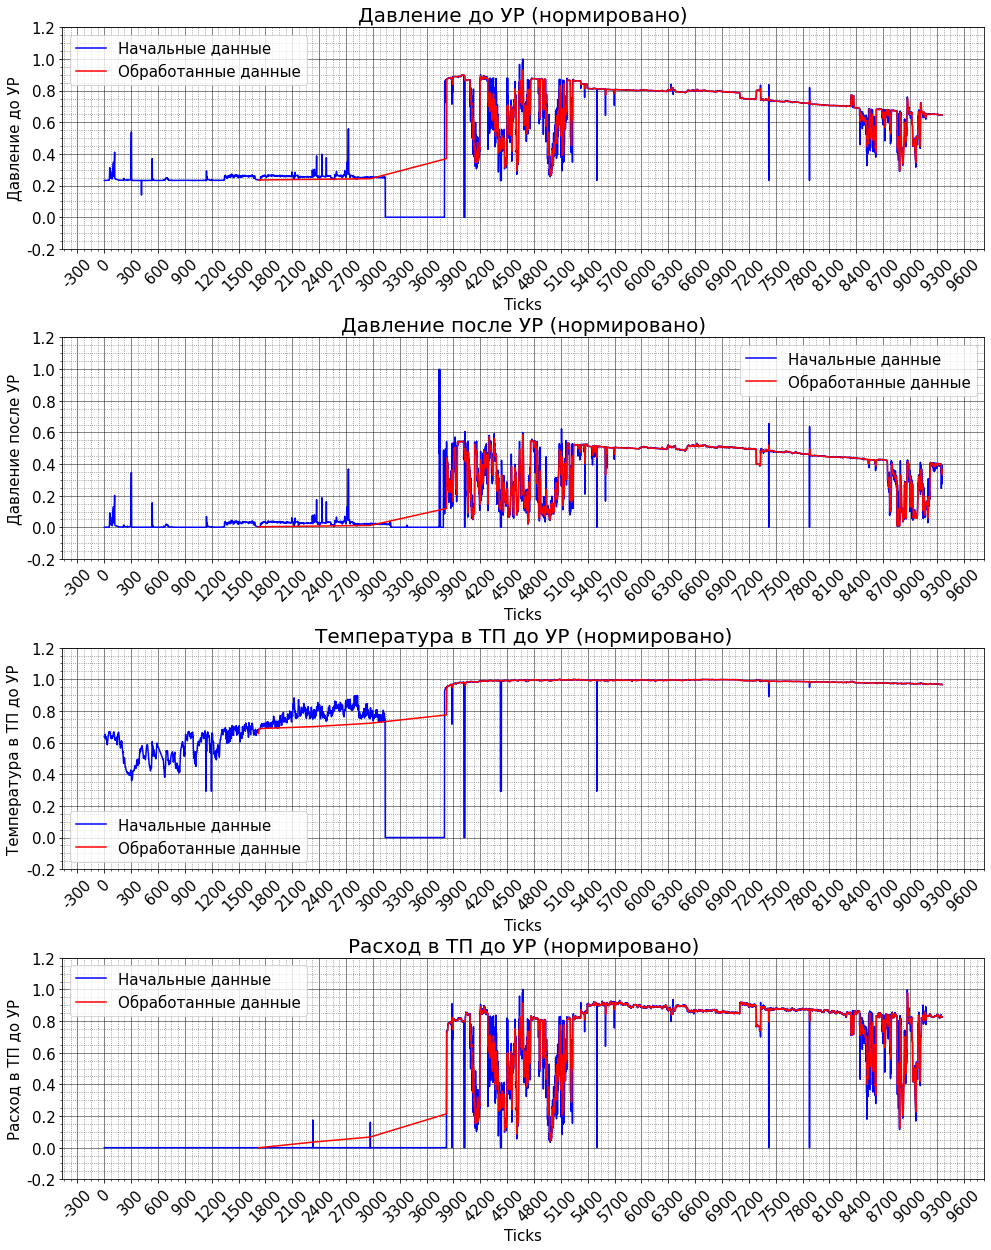

In [24]:
draw_4_graphs_with_overlay_for_2_df(first_df, temp)

In [ ]:
#draw_4_graphs(first_df)

In [ ]:
first_df = prepared_df 
#draw_4_frewuencis_graphs(prepared_df)

In [ ]:
# Удаление выбросов
prepared_df = dp.delete_outliers(prepared_df, soft_mode = False)

In [ ]:
#draw_4_graphs_with_overlay_for_2_df(first_df, prepared_df)

In [ ]:
#draw_4_frewuencis_graphs(prepared_df)

In [ ]:
#draw_4_frewuencis_graphs_with_overlay(first_df, prepared_df)

In [ ]:
#draw_6_relations_graphs(first_df)

In [ ]:
#draw_6_relations_graphs(prepared_df)

## Исследование данных после обработки

In [ ]:
# Общее описание данных до подготовки
#dv.describe_data(prepared_df)

In [ ]:
# Частота встречающихся значений для подготовленых данных
#dv.draw_4_frewuencis_graphs(prepared_df)

In [ ]:
# вывести 4 графика автокорреляции (по графику на столбец) для обработанных данных
#dv.draw_4_autocorrelation_graphs(prepared_df)

In [ ]:
# визуализация данных после подготовки
#dv.draw_4_graphs(prepared_df)

In [ ]:
# вывод графиков отношений столбцов датафрейма без повторений для подготовленных данных
#dv.draw_6_relations_graphs(prepared_df)

# Наглядное сравнение обработанные данных с начальными

In [ ]:
# вывод графиков для сравнения подготовленных данных и начальных (данные относительно времени по столбцам)
#dv.draw_4_graphs_with_overlay_for_2_df(first_df, prepared_df)

# Выводы

Основной вывод - пригодность данных к использованию в обучении после обработки возросла.

Смотрим на матрицу коэффициентов корреляции данных, видим, что

а) корреляция между всеми столбцами имеется

б) после обработки большинство коэффициентов выросли (скорее всего из-за уменьшения кол-ва выбросов)

(однако расчета доверительных интервалов для этих коэффов и выводов о их стат. значимости сделано не было).

Смотрим на гистограммы частот встречающихся значений, видим, что до обработки в данных были крайне редко встречающиеся значения, портящие общую картину (выбросы). Тот же график температуры - это 2 столба, один мелкий - выбросы, другой большой - все нормольные значения. После обработки (удаления редких значений считай) гистограммы стали выглядеть лучше, даже нормальное распределение напоминают.

Смотрим на коррелограммы, видим, что графики до обработки держатся довольно близко к нулю (а чем ближе к нулю, тем случайнее данные, как я понял), та же температура только редкими выбросами от нуля уходит. После обработки графики от этого нуля весомо отдалились (хотя мб такое поведение как раз выбросами и обусловлено ну или тем загадочным белым шумом).

Смотрим на графики параметров относительно времени до и после, видим, что до обработки температура за краткий временной промежуток может измениться от 40 до -40, хотя по идее должна делать это куда дольше и плавнее (после обработки самый большой скачек - от 49 до 40). Да и вообще по графику и не скажешь общую тенденцию, ибо большая его часть - горизонтальная линия. В целом, то же самое можно и о других сказать. После обработки данные стали выглядеть лучше.

Есть еще кляксообразные графики зависимостей каждой переменной от каждой, но по ним мало что можно сказать, разве что то, что в них можно условно разглядеть графики, описывающие общую тенденцию, что намекает на то, что разработка нейросети для работы с этими данными не совсем имеет смысл (кстати после обработки в графиках проще разглядеть тенденции).